# Modeling

In [1]:
#essentials
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#tools/metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import shap

#modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge


In [2]:
os.chdir('..')
full_path = os.getcwd() + "/data/master_table.csv"
full_path

'/Users/ajaysuresh/Desktop/Sports Analytics Projects/NBA-MVP-Project/data/master_table.csv'

In [3]:
master_table = pd.read_csv(full_path)
master_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     355 non-null    int64  
 1   Rank                           355 non-null    object 
 2   Player                         355 non-null    object 
 3   Age                            355 non-null    int64  
 4   Tm                             355 non-null    object 
 5   First                          355 non-null    int64  
 6   Pts Won                        355 non-null    int64  
 7   Pts Max                        355 non-null    int64  
 8   Share                          355 non-null    float64
 9   G                              355 non-null    int64  
 10  MP                             355 non-null    float64
 11  PTS                            355 non-null    float64
 12  TRB                            355 non-null    flo

In [4]:
master_table = master_table.drop(labels=["Unnamed: 0"],axis=1)

In [5]:
master_table.columns

Index(['Rank', 'Player', 'Age', 'Tm', 'First', 'Pts Won', 'Pts Max', 'Share',
       'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS',
       'WS/48', 'year', 'team', 'W', 'W/L%', 'seed', 'games_played',
       'minutes_played', 'player_efficiency_rating',
       'true_shooting_percentage', 'three_point_attempt_rate',
       'free_throw_attempt_rate', 'offensive_rebound_percentage',
       'defensive_rebound_percentage', 'total_rebound_percentage',
       'assist_percentage', 'steal_percentage', 'block_percentage',
       'turnover_percentage', 'usage_percentage', 'offensive_win_shares',
       'defensive_win_shares', 'win_shares', 'win_shares_per_48_minutes',
       'offensive_box_plus_minus', 'defensive_box_plus_minus',
       'box_plus_minus', 'value_over_replacement_player'],
      dtype='object')

### Exploratory Data Analysis

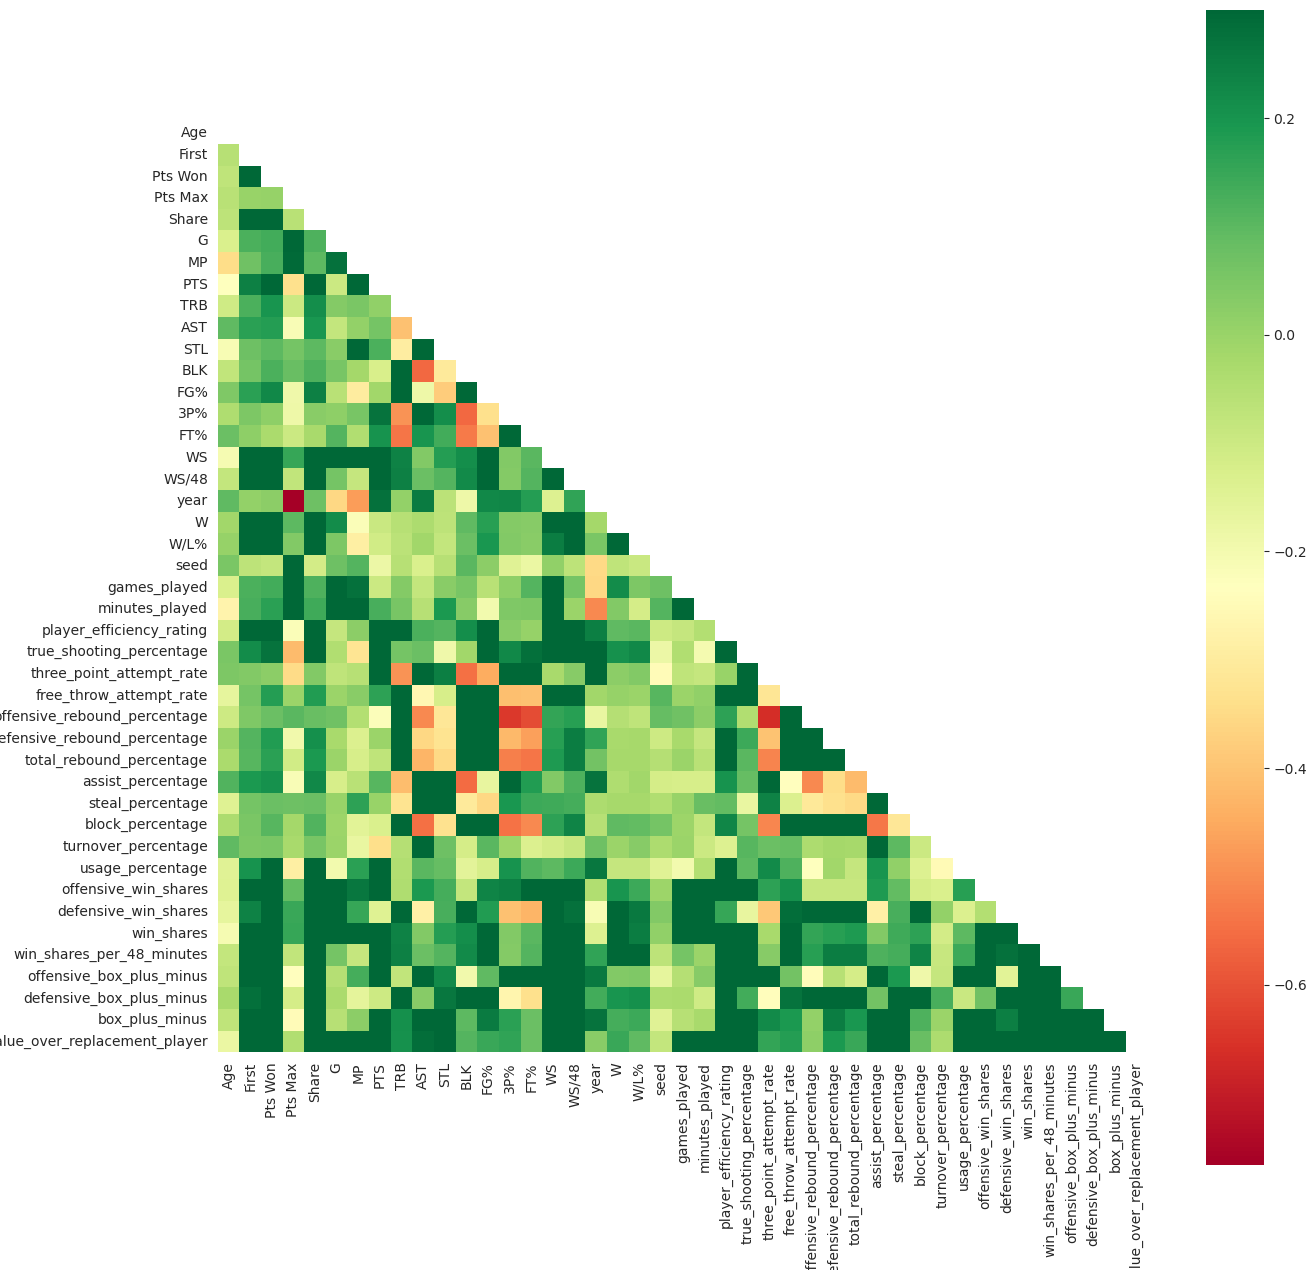

In [6]:
#cols to remove for correlation matrix
cols_to_drop = ['Rank','Player','Tm','team']
#correlations of each features
corr_matrix = master_table.drop(labels=cols_to_drop,axis=1).corr()

#plot heat map
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(corr_matrix, mask=mask, vmax=.3, square=True,cmap="RdYlGn")

### Calculating Mutual Information Scores

In [7]:
def get_best_features(df, target_col='Share', exclude_cols=None, n_top=10):

    #Default Exclusions
    if exclude_cols is None:
        exclude_cols = ['Rank', 'Player', 'Tm', 'team', 'year', 'First', 'Pts Won', 'Pts Max']
    cols_to_ignore = exclude_cols + [target_col]

    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    
    features = [c for c in numeric_df.columns if c not in cols_to_ignore]
    
    analysis_df = df[features + [target_col]].dropna()
    
    X = analysis_df[features]
    y = analysis_df[target_col]
    
    print(f"Analyzing {len(features)} features using {len(analysis_df)} samples...")

    # Calculate Mutual Information
    mi_scores = mutual_info_regression(X, y, discrete_features='auto', random_state=42)

    results_df = pd.DataFrame({
        'Feature': features,
        'MI_Score': mi_scores
    }).sort_values('MI_Score', ascending=False).reset_index(drop=True)

    # Visualize
    plt.figure(figsize=(10, 6))
    sns.barplot(x='MI_Score', y='Feature', data=results_df.head(n_top), palette='viridis')
    plt.title(f'Top Features Predictive of {target_col}')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    return results_df


Analyzing 38 features using 323 samples...


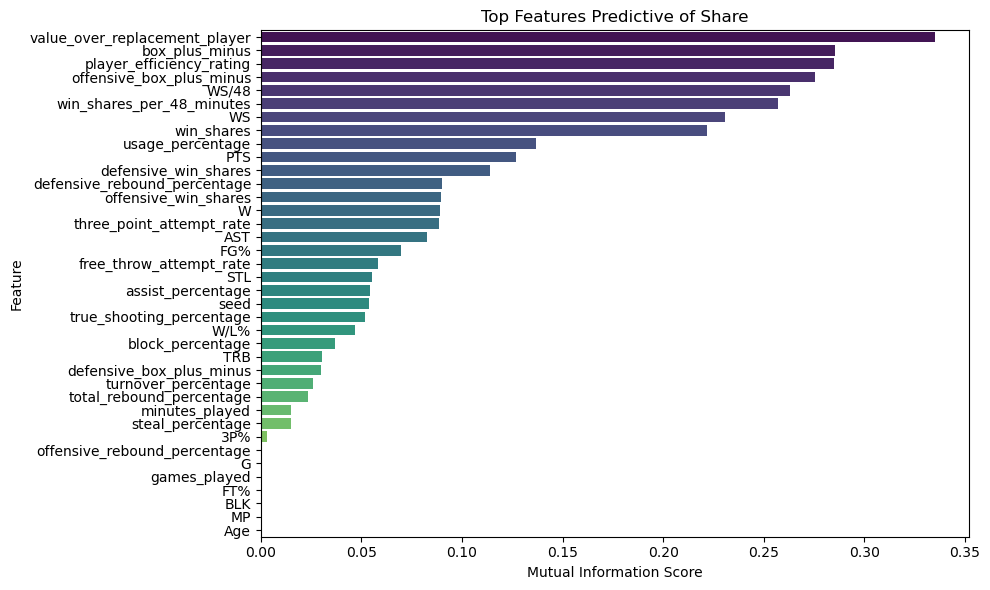

Top Predictors:
                         Feature  MI_Score
0  value_over_replacement_player  0.335180
1                 box_plus_minus  0.285507
2       player_efficiency_rating  0.285118
3       offensive_box_plus_minus  0.275517
4                          WS/48  0.263126
5      win_shares_per_48_minutes  0.256974
6                             WS  0.230713
7                     win_shares  0.221741
8               usage_percentage  0.136975
9                            PTS  0.126692


In [8]:
history_df = master_table[master_table['year'] < 2025]
mi_results = get_best_features(history_df, n_top=len(history_df))
print("Top Predictors:")
print(mi_results.head(10))


### Feature Engineering

In [9]:
def add_win_lose_col(df):
    rank_lst = []
    for i in list(df['Rank']):
        if i == '1':
            rank_lst.append('won')
        else:
            rank_lst.append('lost')
    master_table_rank = df.copy()
    master_table_rank['Win/Lose'] = rank_lst
    return master_table_rank

In [10]:
def show_feature_vs_share(feature, df):
    fig = px.scatter(data_frame = df,
               x=feature,
               y='Share',
               color='Win/Lose',
               color_discrete_sequence=['blue','gray'], 
               hover_data={
                   'Win/Lose': False,
                   'Player': True, 
                   'year': True,
                   'seed': True,
                   'W/L%': True, 
                   'W': True
                   
               })
    fig.update_layout(height=500,
                     title = f"{feature} vs. MVP share")
    fig.show()

In [11]:
features = ['value_over_replacement_player', 'player_efficiency_rating','box_plus_minus',
            'offensive_box_plus_minus', 'WS/48','usage_percentage','seed','W','PTS']

master_table_rank = add_win_lose_col(df=master_table)

for feature in features:
    show_feature_vs_share(feature=feature, df=master_table_rank)

### Modeling

Analyzing 9 features using 323 samples...


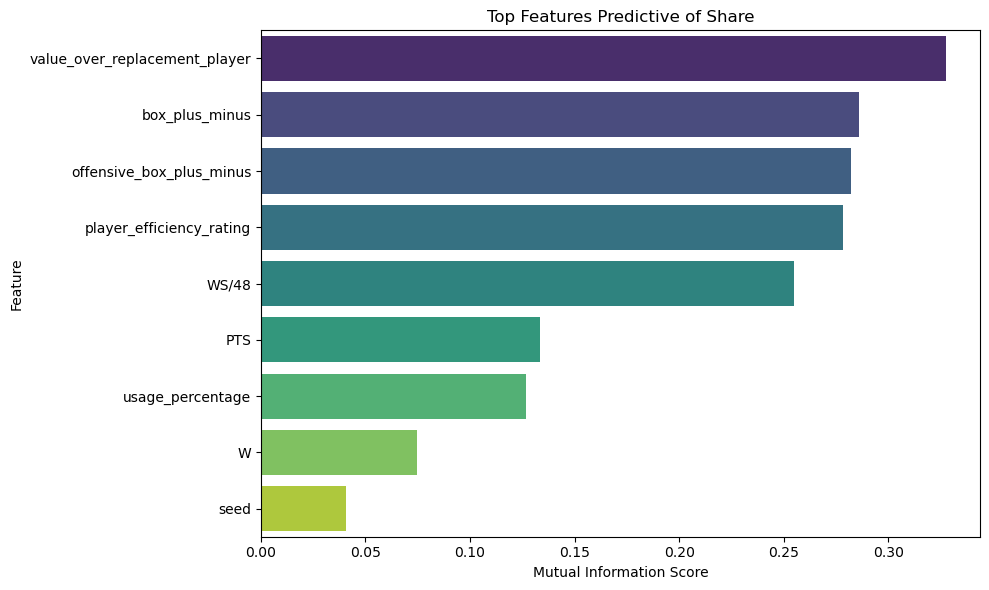

Top Predictors:
                         Feature  MI_Score
0  value_over_replacement_player  0.327488
1                 box_plus_minus  0.285933
2       offensive_box_plus_minus  0.282170
3       player_efficiency_rating  0.278148
4                          WS/48  0.255090
5                            PTS  0.133513
6               usage_percentage  0.126850
7                              W  0.074558
8                           seed  0.040763


In [12]:
cols = features + ['year','Share']
master_table_mi = master_table.copy()

history_df = master_table_mi[master_table['year'] < 2025]
history_df = history_df[cols]
mi_results = get_best_features(history_df, n_top=len(history_df))
print("Top Predictors:")
print(mi_results.head(10))

In [13]:
features = [
    'value_over_replacement_player', 
    'box_plus_minus', 
    'offensive_box_plus_minus', 
    'player_efficiency_rating', 
    'WS/48', 
    'PTS', 
    'usage_percentage', 
    'W', 
    'seed'
]

col_mapping = {
    'win_shares_per_48_minutes': 'WS/48',
    'win_shares': 'WS',
    'games_played': 'G',
    'minutes_played': 'MP',
    'age': 'Age',
    'team': 'Tm'
}

In [14]:
path = os.getcwd() + "/data/current_mvp_candidates.csv"
current_mvp_candidates = pd.read_csv(path)
current_mvp_cleaned = current_mvp_candidates.rename(columns=col_mapping)

print("Checking feature alignment...")
for f in features:
    if f not in master_table.columns:
        print(f"Missing in Master: {f}")
    if f not in current_mvp_cleaned.columns:
        print(f"Missing in Current: {f}")

Checking feature alignment...


In [15]:
# Training: 2000 - 2024
train_df = master_table[master_table['year'] <= 2024].copy()

# Validation: 2025 (The "Simulated Test" - checking if it predicts Jokic/SGA)
val_df = master_table[master_table['year'] == 2025].copy()

# Testing: 2026 (The Future / Current Season)
test_df = current_mvp_cleaned.copy()

X_train = train_df[features].fillna(0)
y_train = train_df['Share'].fillna(0)

X_val = val_df[features].fillna(0)
y_val = val_df['Share'].fillna(0)

X_test = test_df[features].fillna(0)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [16]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42, verbose=-1)
}
performance_records = []

In [17]:
best_model_name = ""
best_mse = float('inf')
best_model_obj = None

print("Running Model Tournament on 2025 Validation Data...\n")

for name, model in models.items():
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict on Validation
    val_preds = model.predict(X_val_scaled)
    
    # Calculate Metrics
    mse = mean_squared_error(y_val, val_preds)
    r2 = r2_score(y_val, val_preds)
    
    # Identify Predicted Winner
    val_check = val_df.copy()
    val_check['Predicted_Share'] = val_preds
    winner_row = val_check.sort_values('Predicted_Share', ascending=False).iloc[0]
    
    # Append to records list
    performance_records.append({
        'Model': name,
        'MSE': mse,
        'R_Squared': r2,
        'Predicted_Winner_2025': winner_row['Player'],
        'Winner_Share_Proj': round(winner_row['Predicted_Share'], 3)
    })
    
    # Track Best Model (based on MSE)
    if mse < best_mse:
        best_mse = mse
        best_model_name = name
        best_model_obj = model

# Create the Results Table
results_df = pd.DataFrame(performance_records)
results_df = results_df.sort_values('MSE', ascending=True) 

print("=== MODEL PERFORMANCE TABLE ===")
print(results_df.to_string(index=False))

Running Model Tournament on 2025 Validation Data...

=== MODEL PERFORMANCE TABLE ===
            Model      MSE  R_Squared   Predicted_Winner_2025  Winner_Share_Proj
         LightGBM 0.004291   0.957554 Shai Gilgeous-Alexander              0.968
          XGBoost 0.004349   0.956981 Shai Gilgeous-Alexander              0.957
    Random Forest 0.004418   0.956307 Shai Gilgeous-Alexander              0.942
 Ridge Regression 0.011864   0.882660 Shai Gilgeous-Alexander              0.696
Linear Regression 0.011952   0.881790 Shai Gilgeous-Alexander              0.695


In [18]:
print(f"\n Selected Best Model: {best_model_name}")
print(f"... Generating 2026 Predictions ...")

test_preds = best_model_obj.predict(X_test_scaled)
test_df['Predicted_Share'] = test_preds
test_df['Predicted_Share'] = test_df['Predicted_Share'].clip(0, 1)

# Rank Top 10
top_candidates_2026 = test_df.sort_values('Predicted_Share', ascending=False).head(10)

print("\n=== 2025-26 MVP PREDICTIONS ===")
print(top_candidates_2026[['Player','Predicted_Share']])


 Selected Best Model: LightGBM
... Generating 2026 Predictions ...

=== 2025-26 MVP PREDICTIONS ===
                    Player  Predicted_Share
8    Giannis Antetokounmpo         0.469227
0             Nikola Jokić         0.466863
1  Shai Gilgeous-Alexander         0.449870
2              Luka Dončić         0.418769
6              Jalen Duren         0.016775
3          Cade Cunningham         0.014913
4            Austin Reaves         0.012972
9             Tyrese Maxey         0.008281
5       Isaiah Hartenstein         0.000000
7           Alperen Şengün         0.000000


In [19]:
# Export Predictions
submission = test_df[['Player', 'Predicted_Share']].copy()
submission.columns = ['player_name', 'probability']
submission.to_csv('predictions.csv', index=False)
print("predictions.csv saved.")

predictions.csv saved.
